In [1]:
"""
@author:  <Mohammed Awal Kassim>
@contact: <mkass005@uottawa.ca>
@version: 1.0
@summary: <This is the solution to the third homework of the CSI 5155(Machine Learning) course at the University of Ottawa.>
"""

# Importing useful libraries
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, recall_score, precision_score
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from imblearn.over_sampling import RandomOverSampler

The best performing model from the previous assignments (in terms of accuracy) is the decision tree model trained on the original dataset. It achieves an accuracy of 98.03% with cross validation.

# All data acquision and  Preprocessing steps from previous assignment
- Fetch data from UCI repository
- Load data into local workspace
- Drop irrelevant columns(ID) and instances(semer == 1)
- Scale features
- Binarization
- Feature selection

In [2]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"
STORAGE_PATH = os.path.join("datasets", "drug")
DRUG_FEATURES = ["id", "age", "gender", "education", "country", "ethnicity", "nscore", "escore", "oscore", "ascore", "cscore", "impulsive", "ss"]
CLASSES = ["alcohol", "amphet", "amyl", "benzos", "caff", "cannabis", "choc", "coke", "crack", "ecstasy", "heroine", "ketamin", "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]

def get_data(url, path, file_name):
  """
  Fetches data from the internet given the url
  :param:url: location of dataset on the internet
  :param:path: destination in local environment
  """
  data = os.path.join(path, file_name)
  os.makedirs(path, exist_ok=True)
  urllib.request.urlretrieve(url, data)

def load_data(path, file_name ):
  """
  Loads data from the local environment
  :param: path: data directory
  :return: pandas dataframe containing data
  """
  data_file = os.path.join(path, file_name)
  return pd.read_csv(data_file,  names = DRUG_FEATURES + CLASSES)

def preprocess_data(data):
  """
  Performs data preprocessing 
  :param:data: pandas dataframe containing input data
  :return: pandas dataframe containing preprocessed data
  """
  data = data[DRUG_FEATURES + ["semer", "caff"]]
  data = data[data.semer == "CL0"]
  data = data.drop(columns = ["id", "semer"])
  return data

def scale_features(X):
  data = MinMaxScaler().fit_transform(X)
  return data

def binarize_labels(data):
  """
  Converts the multi class labels to binary
  :param:data: pandas dataframe containing input data
  :return: six dataframes representing consumers of alcohol, amphet, cannabis, chocolate, mushrooms, and nicotine
  """
  label = "caff"
  data[label] = data[label].replace(["CL0", "CL1"], 0)
  data[label] = data[label].replace(["CL2", "CL3", "CL4", "CL5", "CL6"], 1)
  data[label].astype(float)

  # Drop all null values
  data.dropna(inplace=True)
  return data

def select_features(dataset):
  """
  Selects features that are relevant to the classification task using feature importance
  :param: dataset: input data
  :return: a dataframes containing selected features alongside their classes
  """
  class_name = dataset.columns[-1]
  class_name
  #new_classes.remove("semer")
  dataset.shape
  X_train = dataset.drop(dataset.columns[-1], axis=1)
  y_train = dataset[dataset.columns[-1]].copy()

  classifier = LogisticRegression()
  classifier.fit(X_train, y_train)
  model = SelectFromModel(classifier, prefit=True)
  feature_idx = model.get_support()
  feature_names = X_train.columns[feature_idx]
  print(feature_names)
  X_train_new = model.transform(X_train)
  X_train_new = pd.DataFrame(X_train_new, columns=feature_names)
  column_names = list(feature_names) + [class_name]
  X_train_new.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  new_data = pd.concat([X_train_new, y_train], axis=1, ignore_index=True)
  new_data.columns = column_names
  new_data.shape


  return new_data

In [3]:
get_data(DATA_URL, STORAGE_PATH, "drug_consumption.data" )
drug_data = load_data(STORAGE_PATH, "drug_consumption.data" )
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1885 non-null   int64  
 1   age        1885 non-null   float64
 2   gender     1885 non-null   float64
 3   education  1885 non-null   float64
 4   country    1885 non-null   float64
 5   ethnicity  1885 non-null   float64
 6   nscore     1885 non-null   float64
 7   escore     1885 non-null   float64
 8   oscore     1885 non-null   float64
 9   ascore     1885 non-null   float64
 10  cscore     1885 non-null   float64
 11  impulsive  1885 non-null   float64
 12  ss         1885 non-null   float64
 13  alcohol    1885 non-null   object 
 14  amphet     1885 non-null   object 
 15  amyl       1885 non-null   object 
 16  benzos     1885 non-null   object 
 17  caff       1885 non-null   object 
 18  cannabis   1885 non-null   object 
 19  choc       1885 non-null   object 
 20  coke    

In [4]:
new_drug_data = preprocess_data(drug_data)
new_drug_data = binarize_labels(new_drug_data)
new_drug_columns = new_drug_data.columns
#new_drug_X = new_drug_data.drop(labels=["caff"], axis=1)
new_drug_data = scale_features(new_drug_data)
new_drug_data.shape

(1877, 13)

In [5]:
new_drug = pd.DataFrame(new_drug_data)
new_drug.columns = new_drug_columns
new_drug.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,caff
0,0.409137,1.0,0.537681,1.0,0.409061,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398,1.0
1,0.246475,0.0,1.000000,1.0,0.262143,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658,1.0
2,0.409137,0.0,0.537681,1.0,0.262143,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957,1.0
3,0.000000,1.0,0.814329,1.0,0.262143,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398,1.0
4,0.409137,1.0,1.000000,1.0,0.262143,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658,1.0


In [6]:
new_drug.describe()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,caff
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,0.279243,0.499201,0.550853,0.606877,0.264506,0.514049,0.499702,0.529623,0.499905,0.499943,0.469233,0.517741,0.980288
std,0.247874,0.500133,0.214880,0.457053,0.055144,0.148174,0.152327,0.161231,0.143849,0.143989,0.174853,0.240506,0.139047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.412820,0.000000,0.262143,0.413474,0.393845,0.413998,0.412490,0.405822,0.337920,0.388117,1.000000
50%,0.246475,0.000000,0.537681,1.000000,0.262143,0.520448,0.500507,0.527023,0.497505,0.499040,0.428474,0.539559,1.000000
75%,0.409137,1.000000,0.653938,1.000000,0.262143,0.607577,0.597404,0.647268,0.609827,0.584415,0.565343,0.710933,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
dataset1 = select_features(new_drug)
dataset1.info()

Index(['age', 'country', 'ethnicity', 'escore', 'oscore', 'cscore', 'ss'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877 entries, 0 to 1876
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1877 non-null   float64
 1   country    1877 non-null   float64
 2   ethnicity  1877 non-null   float64
 3   escore     1877 non-null   float64
 4   oscore     1877 non-null   float64
 5   cscore     1877 non-null   float64
 6   ss         1877 non-null   float64
 7   caff       1877 non-null   float64
dtypes: float64(8)
memory usage: 117.4 KB


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


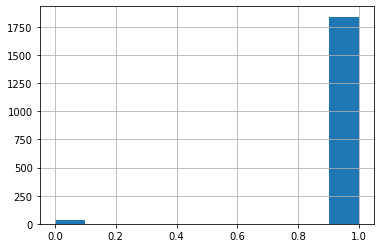

In [8]:
ax = plt.subplot()
dataset1['caff'].hist(ax=ax)
plt.savefig("distribution.png")

### Train a decision tree and visualize the resulting model

In [9]:
classifier = DecisionTreeClassifier()

x = dataset1.drop(columns=["caff"])
y = dataset1[new_drug_columns[-1]].copy()

# Hyper parameter tuning
parameters ={
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15],
    "min_samples_split": range(2, 10),
    "min_samples_leaf": range(2, 5)
}
# Search for best parameters with 10 fold cross validation
grid = GridSearchCV(
    classifier,
    param_grid=parameters,
    cv=10,
    verbose=1,
    n_jobs=-1
)

grid.fit(x, y)
grid.best_params_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [10]:
grid.best_score_

0.97869211514393

In [11]:
new_drug_columns

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss', 'caff'],
      dtype='object')

In [12]:
# Use best parameters to train model
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, min_samples_split=2)
classifier.fit(x, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2)

In [13]:
export_graphviz(classifier, out_file="tree.dot", feature_names=dataset1.columns[:len(dataset1.columns)-1], class_names=["0", "1"], rounded=True, filled=True)
!dot -Tpng tree.dot -o tree.png

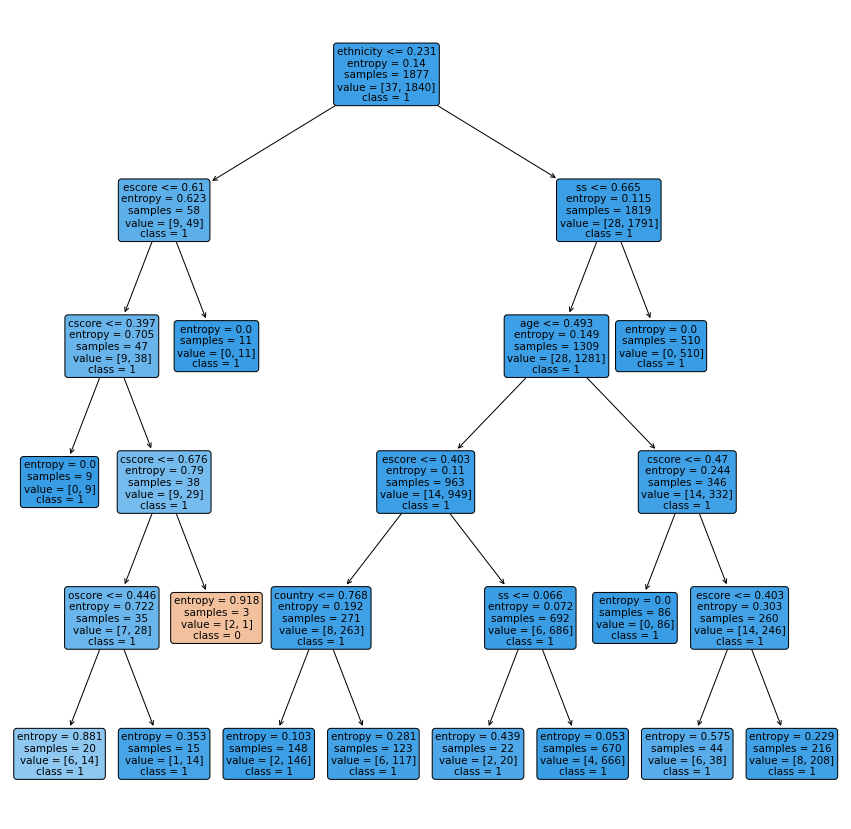

In [14]:
fig = plt.figure(figsize=(15, 15))
viz = tree.plot_tree(classifier, feature_names=dataset1.columns[:len(dataset1.columns)-1], class_names=["0", "1"], rounded=True, filled=True)
fig.savefig("tree_d.pdf")